In [1]:
!pip install --quiet vit-keras
!pip install tensorflow_addons

#Using our merged dataset train & test data

This Task is (SEB VS NEVUS)

In [3]:
#Sset title for saving model correctly!!!
title = "seb_vs_nev_aug_batch_norm"

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools
import keras
from keras import backend as K
import tensorflow
from tensorflow.keras.layers import Dropout, Dense, LayerNormalization, Flatten
from tensorflow.keras.activations import gelu
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from vit_keras import vit
import tensorflow_addons as tfa
import math
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
from zipfile import ZipFile
import time
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import  precision_score, recall_score, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import backend as K

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [5]:
#Initializing the ViT model
vit_model = vit.vit_b16(
        image_size = 224,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 2)

347502902/347502902 [==============================] - 7s 0us/step


/opt/conda/lib/python3.10/site-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


In [6]:
#Adding additional layer on top of ViT model
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(11, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(2, 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (BatchN  (None, 768)              3072      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 11)                8459      
                                                                 
 batch_normalization_1 (Batc  (None, 11)               44        
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 2)          

In [7]:
#Compiling model using binary cross entropy and adam optimizer
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [8]:
early_stopping = EarlyStopping(monitor='val_loss',patience=2)               #Configure early stopping criteria

def step_decay(epoch):
    initial_lrate = 0.00002                                                 #Configure learning rate
    drop = 0.1
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(step_decay, verbose=1)

In [9]:
#Function for plotting train and validation accuracy and loss
def graph_it(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Model Accuracy: Training and Validation')
  plt.legend(loc=0)
  plt.figure()

  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation Loss')
  plt.legend(loc=0)
  plt.figure()


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, precision_score, roc_curve, ConfusionMatrixDisplay

def test_it(model, test_generator):
    test_labels = test_generator.classes

    predictions = model.predict(test_generator)
    predicted_labels = np.argmax(predictions, axis=1)

    cm = confusion_matrix(test_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    roc = roc_auc_score(test_labels, predictions[:, 1])  # Calculating ROC score

    # Calculate confusion matrix 
    tn, fp, fn, tp = confusion_matrix(test_labels, predicted_labels).ravel()

    # Calculate sensitivity and specificity
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    report = classification_report(test_labels, predicted_labels)           #Classification report

    precision = precision_score(test_labels, predicted_labels, average='weighted')  #Calculating precision score

    print("\n", report)
    print(f"Sensitivity: {round(sensitivity, 3)} Specificity: {round(specificity, 3)} Precision: {round(precision, 3)} ROC_AUC_SCORE: {round(roc, 3)}\n")

    # Plot AUC-ROC curve
    fpr, tpr, thresholds = roc_curve(test_labels, predictions[:, 1])
    plt.figure(figsize=(4, 4))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc)
    plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [11]:
# Set the directories for the data for task1 (SEB VS NEVUS)
train_dir = "/kaggle/input/isic-seb-vs-nevu/train_splited_augumented/train_splited_augumented"
test_dir = "/kaggle/input/isic-seb-vs-nevu/test_splited/test_splited"

In [12]:
# Combine the paths and corresponding labels for the stratified k-fold
train_paths = []
train_labels = []
for class_folder in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_folder)
    if os.path.isdir(class_path):
        class_label = class_folder
        for image_filename in os.listdir(class_path):
            train_paths.append(os.path.join(class_path, image_filename))
            train_labels.append(class_label)

train_paths = np.array(train_paths)
train_labels = np.array(train_labels)

In [13]:
# Define the data generator
datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.mobilenet.preprocess_input)

image_size = (224, 224)
batch = 10
num_fold = 5

# Initialize the stratified k-fold object
skf = StratifiedKFold(n_splits=num_fold, shuffle=True, random_state=None)

In [14]:
model_path = f'/kaggle/working/model/{title}'
os.makedirs(model_path, exist_ok=True)

Traning for Fold: 1
Found 7804 validated image filenames belonging to 2 classes.
Found 1952 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
79/79 [==============================] - ETA: 0s - loss: 0.7696 - accuracy: 0.6365
Epoch 1: val_accuracy improved from -inf to 0.78500, saving model to /kaggle/working/model/seb_vs_nev_aug_batch_norm/model_fold_1_batch_norm.hdf5
79/79 [==============================] - 82s 347ms/step - loss: 0.7696 - accuracy: 0.6365 - val_loss: 0.6376 - val_accuracy: 0.7850 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
79/79 [==============================] - ETA: 0s - loss: 0.6576 - accuracy: 0.7063
Epoch 2: val_accuracy improved from 0.78500 to 0.82000, saving model to /kaggle/working/model/seb_vs_nev_aug_batch_norm/model_fold_1_batch_norm.hdf5
79/79 [==============================] - 24s 308ms/step - loss: 0.6576 - accuracy: 0.7063 - val_lo

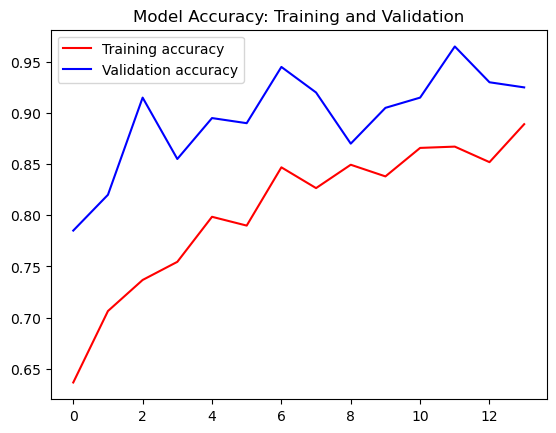

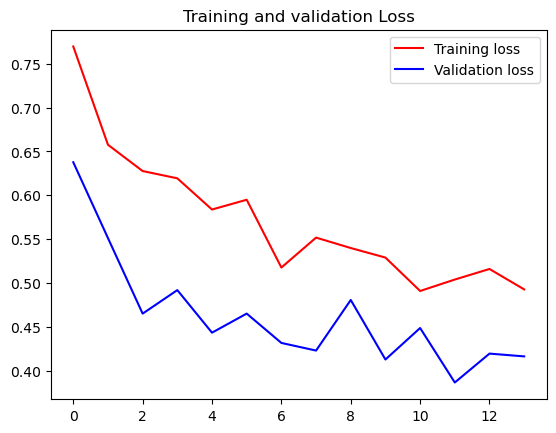

<Figure size 640x480 with 0 Axes>

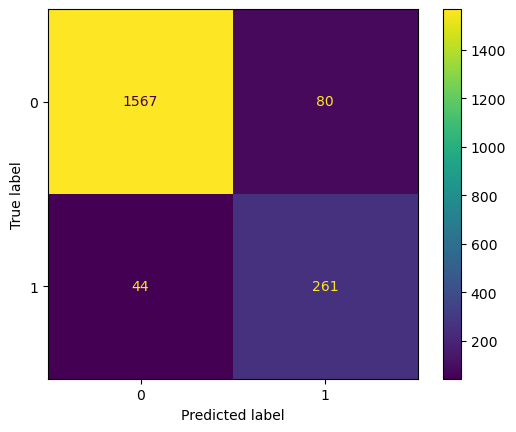


               precision    recall  f1-score   support

           0       0.97      0.95      0.96      1647
           1       0.77      0.86      0.81       305

    accuracy                           0.94      1952
   macro avg       0.87      0.90      0.88      1952
weighted avg       0.94      0.94      0.94      1952

Sensitivity: 0.856 Specificity: 0.951 Precision: 0.94 ROC_AUC_SCORE: 0.958



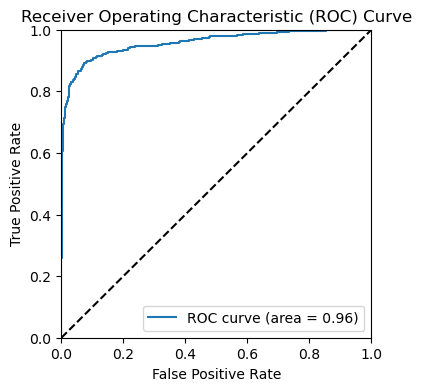

Validation complete...
Traning for Fold: 2
Found 7805 validated image filenames belonging to 2 classes.
Found 1951 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
79/79 [==============================] - ETA: 0s - loss: 0.5143 - accuracy: 0.8557
Epoch 1: val_accuracy improved from -inf to 0.93000, saving model to /kaggle/working/model/seb_vs_nev_aug_batch_norm/model_fold_2_batch_norm.hdf5
79/79 [==============================] - 82s 354ms/step - loss: 0.5143 - accuracy: 0.8557 - val_loss: 0.3929 - val_accuracy: 0.9300 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
79/79 [==============================] - ETA: 0s - loss: 0.5194 - accuracy: 0.8481
Epoch 2: val_accuracy did not improve from 0.93000
79/79 [==============================] - 24s 304ms/step - loss: 0.5194 - accuracy: 0.8481 - val_loss: 0.3746 - val_accuracy: 0.9300 - lr: 2.0000e-05

Epoch 3: LearningRateSc

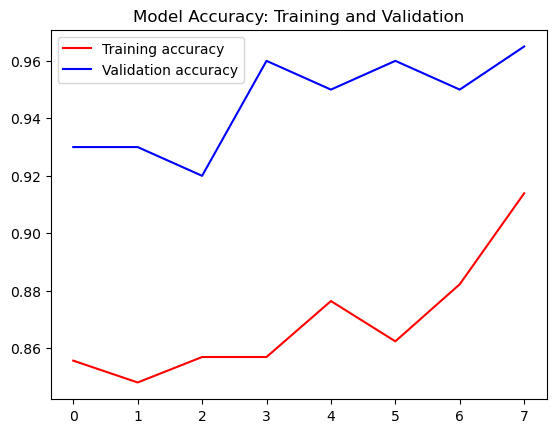

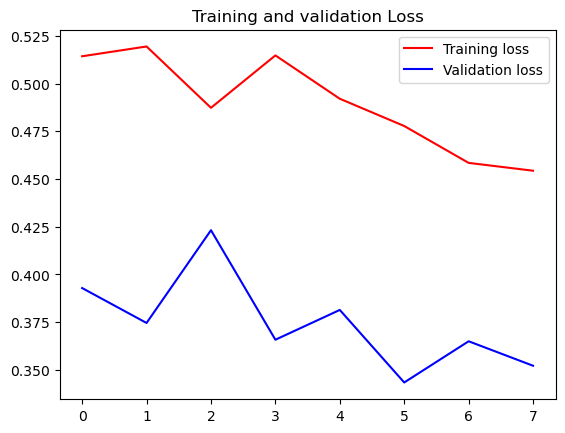

<Figure size 640x480 with 0 Axes>

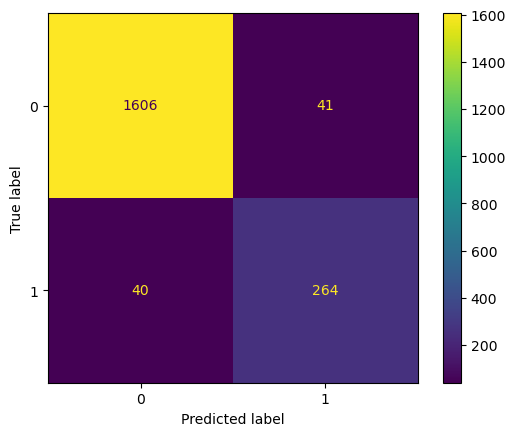


               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1647
           1       0.87      0.87      0.87       304

    accuracy                           0.96      1951
   macro avg       0.92      0.92      0.92      1951
weighted avg       0.96      0.96      0.96      1951

Sensitivity: 0.868 Specificity: 0.975 Precision: 0.959 ROC_AUC_SCORE: 0.972



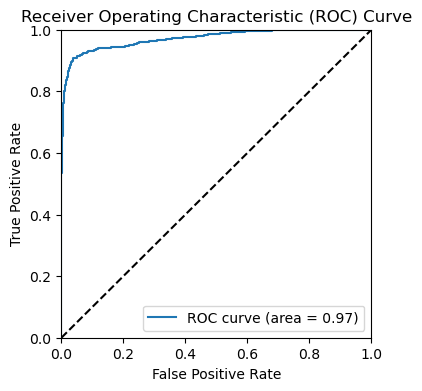

Validation complete...
Traning for Fold: 3
Found 7805 validated image filenames belonging to 2 classes.
Found 1951 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
79/79 [==============================] - ETA: 0s - loss: 0.4657 - accuracy: 0.8924
Epoch 1: val_accuracy improved from -inf to 0.97500, saving model to /kaggle/working/model/seb_vs_nev_aug_batch_norm/model_fold_3_batch_norm.hdf5
79/79 [==============================] - 75s 346ms/step - loss: 0.4657 - accuracy: 0.8924 - val_loss: 0.3309 - val_accuracy: 0.9750 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
79/79 [==============================] - ETA: 0s - loss: 0.4565 - accuracy: 0.9000
Epoch 2: val_accuracy did not improve from 0.97500
79/79 [==============================] - 24s 298ms/step - loss: 0.4565 - accuracy: 0.9000 - val_loss: 0.3459 - val_accuracy: 0.9500 - lr: 2.0000e-05

Epoch 3: LearningRateSc

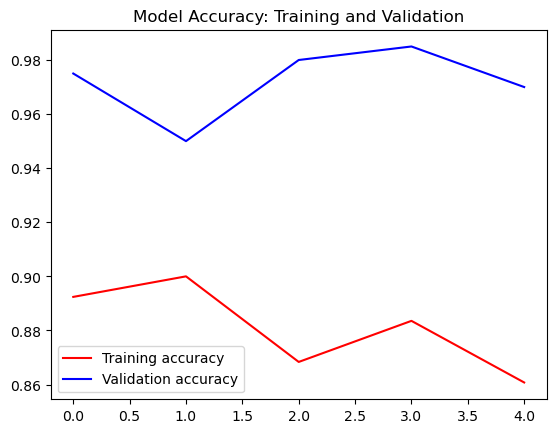

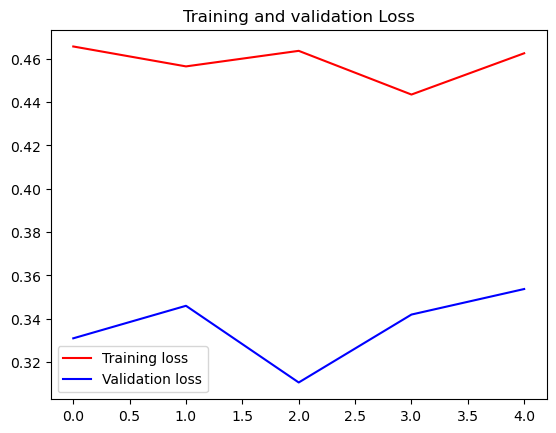

<Figure size 640x480 with 0 Axes>

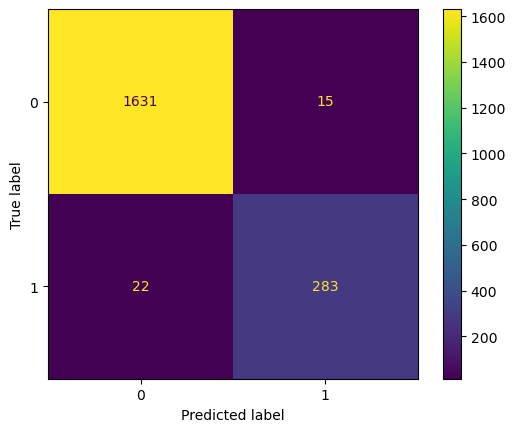


               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1646
           1       0.95      0.93      0.94       305

    accuracy                           0.98      1951
   macro avg       0.97      0.96      0.96      1951
weighted avg       0.98      0.98      0.98      1951

Sensitivity: 0.928 Specificity: 0.991 Precision: 0.981 ROC_AUC_SCORE: 0.989



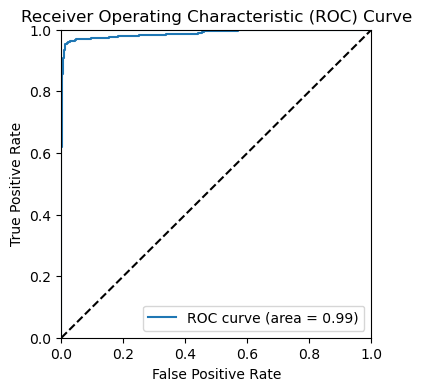

Validation complete...
Traning for Fold: 4
Found 7805 validated image filenames belonging to 2 classes.
Found 1951 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
79/79 [==============================] - ETA: 0s - loss: 0.4572 - accuracy: 0.8962
Epoch 1: val_accuracy improved from -inf to 0.98500, saving model to /kaggle/working/model/seb_vs_nev_aug_batch_norm/model_fold_4_batch_norm.hdf5
79/79 [==============================] - 82s 359ms/step - loss: 0.4572 - accuracy: 0.8962 - val_loss: 0.2932 - val_accuracy: 0.9850 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
79/79 [==============================] - ETA: 0s - loss: 0.3923 - accuracy: 0.9038
Epoch 2: val_accuracy improved from 0.98500 to 0.99000, saving model to /kaggle/working/model/seb_vs_nev_aug_batch_norm/model_fold_4_batch_norm.hdf5
79/79 [==============================] - 25s 320ms/step - loss: 0.3923 - ac

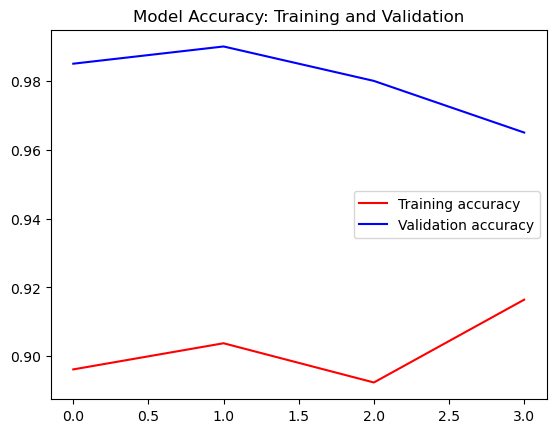

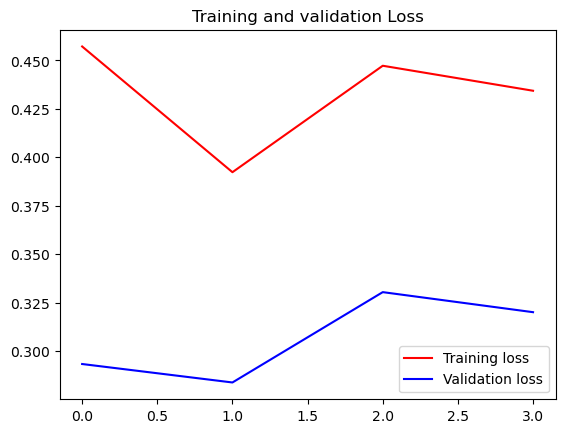

<Figure size 640x480 with 0 Axes>

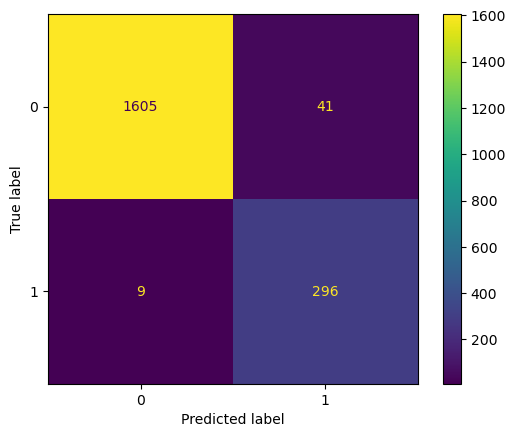


               precision    recall  f1-score   support

           0       0.99      0.98      0.98      1646
           1       0.88      0.97      0.92       305

    accuracy                           0.97      1951
   macro avg       0.94      0.97      0.95      1951
weighted avg       0.98      0.97      0.97      1951

Sensitivity: 0.97 Specificity: 0.975 Precision: 0.976 ROC_AUC_SCORE: 0.996



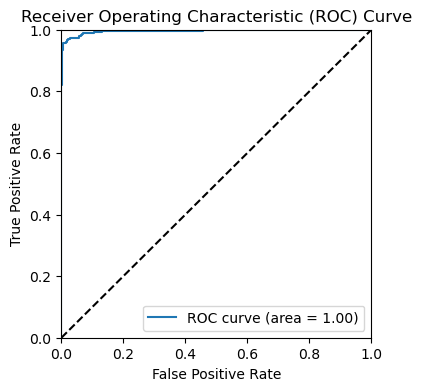

Validation complete...
Traning for Fold: 5
Found 7805 validated image filenames belonging to 2 classes.
Found 1951 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
79/79 [==============================] - ETA: 0s - loss: 0.4115 - accuracy: 0.9025
Epoch 1: val_accuracy improved from -inf to 0.98000, saving model to /kaggle/working/model/seb_vs_nev_aug_batch_norm/model_fold_5_batch_norm.hdf5
79/79 [==============================] - 74s 344ms/step - loss: 0.4115 - accuracy: 0.9025 - val_loss: 0.3010 - val_accuracy: 0.9800 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
79/79 [==============================] - ETA: 0s - loss: 0.4158 - accuracy: 0.8835
Epoch 2: val_accuracy did not improve from 0.98000
79/79 [==============================] - 24s 304ms/step - loss: 0.4158 - accuracy: 0.8835 - val_loss: 0.3582 - val_accuracy: 0.9600 - lr: 2.0000e-05

Epoch 3: LearningRateSc

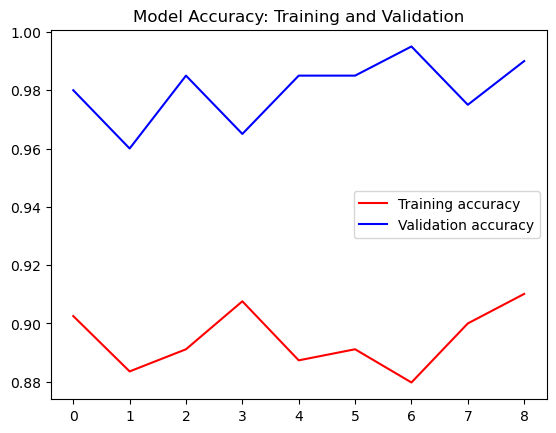

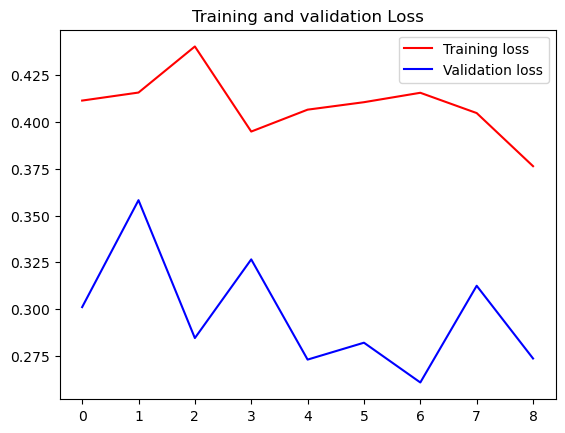

<Figure size 640x480 with 0 Axes>

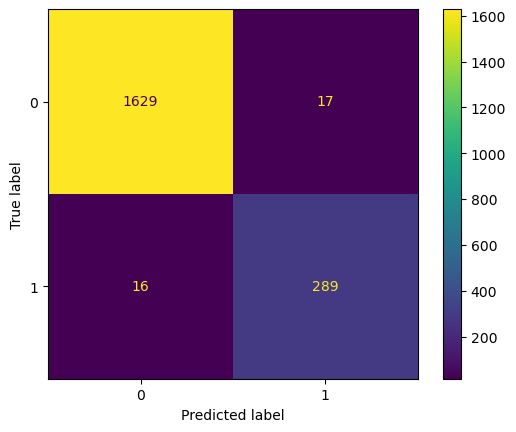


               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1646
           1       0.94      0.95      0.95       305

    accuracy                           0.98      1951
   macro avg       0.97      0.97      0.97      1951
weighted avg       0.98      0.98      0.98      1951

Sensitivity: 0.948 Specificity: 0.99 Precision: 0.983 ROC_AUC_SCORE: 0.998



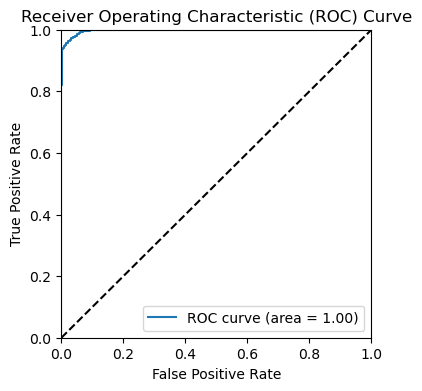

Validation complete...


In [15]:
# Perform k-fold cross-validation
fold = 1
for i, (train_index, val_index) in enumerate(skf.split(train_paths, train_labels)):
    print(f"Traning for Fold: {fold}")
    # Split the data into train and validation sets for this fold
    train_paths_fold, val_paths_fold = train_paths[train_index], train_paths[val_index]
    train_labels_fold, val_labels_fold = train_labels[train_index], train_labels[val_index]

    # Create data generators for this fold
    train_generator_fold = datagen.flow_from_dataframe(
        pd.DataFrame({'filename': train_paths_fold, 'class': train_labels_fold}),
        directory=train_dir,
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=batch
    )

    val_generator_fold = datagen.flow_from_dataframe(
      pd.DataFrame({'filename': val_paths_fold, 'class': val_labels_fold}),
      directory=train_dir,
      x_col='filename',
      y_col='class',
      target_size=image_size,
      batch_size=batch
  )

    train_steps = np.ceil(len(train_generator_fold) / batch)
    val_steps = np.ceil(len(val_generator_fold) / batch)

    #set path to save model
    checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = model_path + f'/model_fold_{fold}_batch_norm.hdf5',
                                                  monitor = 'val_accuracy',
                                                  verbose = 1,
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

    callbacks = [early_stopping, checkpointer, lr_scheduler]


    # Compile the model
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

    # Train the model on the training data and evaluate on the validation data
    history = model.fit(
        train_generator_fold,
        steps_per_epoch=train_steps,
        validation_data=val_generator_fold,
        validation_steps=val_steps,
        epochs=30,
        callbacks=callbacks)

    #Potting graph of train and validation accuracy and loss
    graph_it(history)


    val_generator_fold_test = datagen.flow_from_dataframe(
        pd.DataFrame({'filename': val_paths_fold, 'class': val_labels_fold}),
        directory=train_dir,
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=1,
        shuffle=False
    )

    print(f"\nValidating for fold {fold}... \n")
    print("Loading model...")

    model.load_weights(filepath = model_path + f'/model_fold_{fold}_batch_norm.hdf5')
    test_it(model, val_generator_fold_test)

    print("Validation complete...")

    fold += 1


**Model Evaluation using test data**

In [16]:
test_dir

'/kaggle/input/isic-seb-vs-nevu/test_splited/test_splited'

In [17]:
test_generator = datagen.flow_from_directory(
        test_dir,
        target_size=image_size,
        batch_size=1,
        shuffle=False
    )
test_generator.shuffle = False

Found 483 images belonging to 2 classes.


Test using model 1
483/483 [==============================] - 16s 32ms/step


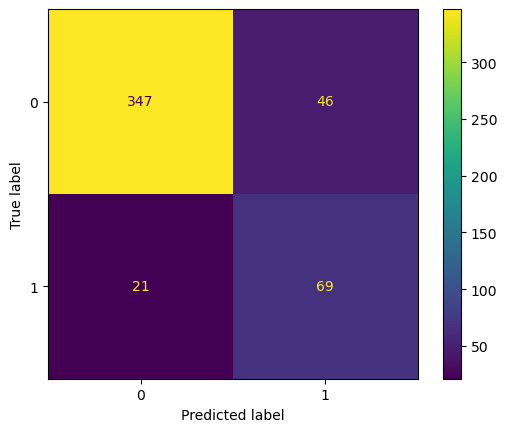


               precision    recall  f1-score   support

           0       0.94      0.88      0.91       393
           1       0.60      0.77      0.67        90

    accuracy                           0.86       483
   macro avg       0.77      0.82      0.79       483
weighted avg       0.88      0.86      0.87       483

Sensitivity: 0.767 Specificity: 0.883 Precision: 0.879 ROC_AUC_SCORE: 0.904



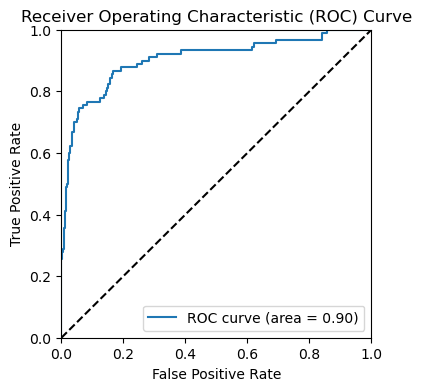

Testing Complete
Test using model 2
483/483 [==============================] - 16s 33ms/step


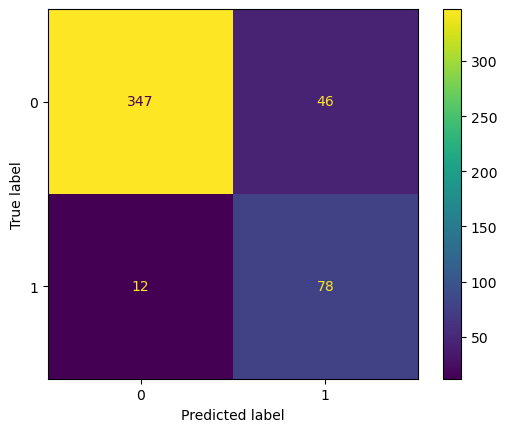


               precision    recall  f1-score   support

           0       0.97      0.88      0.92       393
           1       0.63      0.87      0.73        90

    accuracy                           0.88       483
   macro avg       0.80      0.87      0.83       483
weighted avg       0.90      0.88      0.89       483

Sensitivity: 0.867 Specificity: 0.883 Precision: 0.904 ROC_AUC_SCORE: 0.934



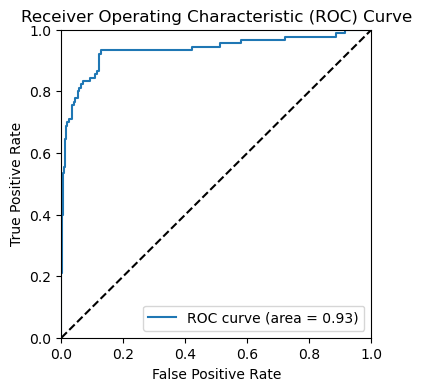

Testing Complete
Test using model 3
483/483 [==============================] - 16s 32ms/step


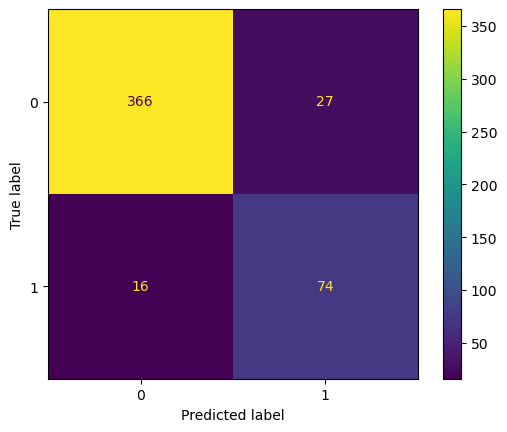


               precision    recall  f1-score   support

           0       0.96      0.93      0.94       393
           1       0.73      0.82      0.77        90

    accuracy                           0.91       483
   macro avg       0.85      0.88      0.86       483
weighted avg       0.92      0.91      0.91       483

Sensitivity: 0.822 Specificity: 0.931 Precision: 0.916 ROC_AUC_SCORE: 0.92



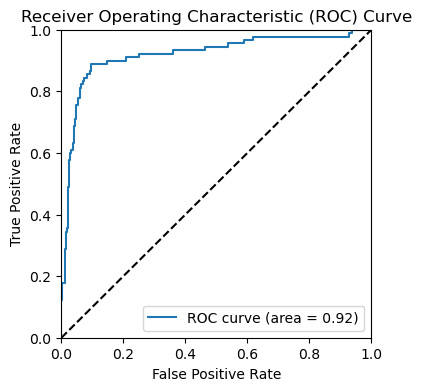

Testing Complete
Test using model 4
483/483 [==============================] - 16s 33ms/step


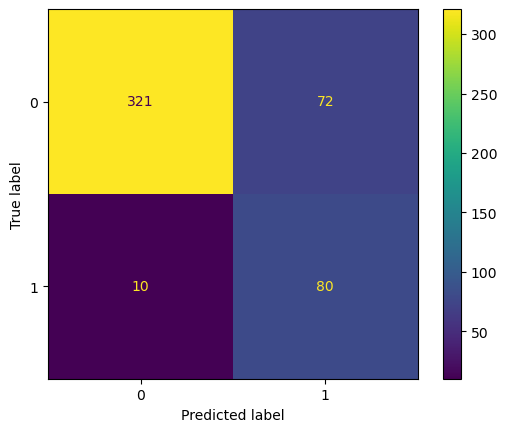


               precision    recall  f1-score   support

           0       0.97      0.82      0.89       393
           1       0.53      0.89      0.66        90

    accuracy                           0.83       483
   macro avg       0.75      0.85      0.77       483
weighted avg       0.89      0.83      0.84       483

Sensitivity: 0.889 Specificity: 0.817 Precision: 0.887 ROC_AUC_SCORE: 0.94



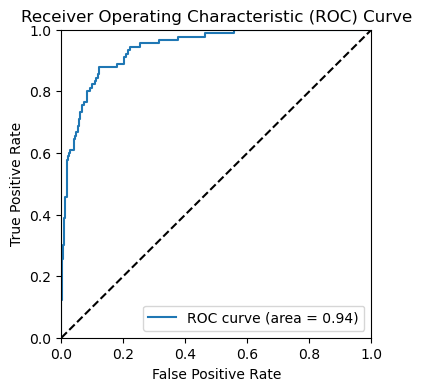

Testing Complete
Test using model 5
483/483 [==============================] - 16s 33ms/step


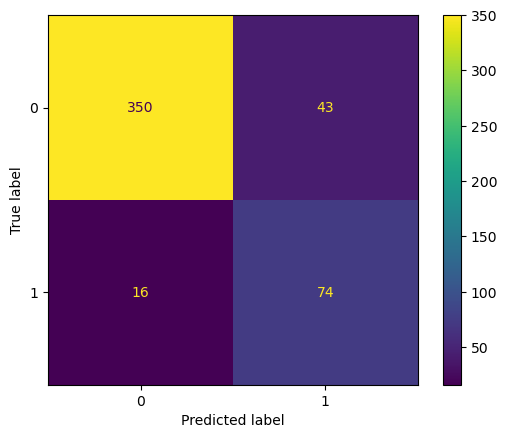


               precision    recall  f1-score   support

           0       0.96      0.89      0.92       393
           1       0.63      0.82      0.71        90

    accuracy                           0.88       483
   macro avg       0.79      0.86      0.82       483
weighted avg       0.90      0.88      0.88       483

Sensitivity: 0.822 Specificity: 0.891 Precision: 0.896 ROC_AUC_SCORE: 0.923



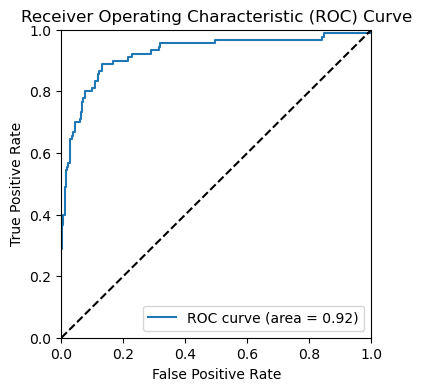

Testing Complete


In [18]:
#set path to best weights from your training please manually! {title}_fold_{fold}
for i in range(1, num_fold+1):
  print(f"Test using model {i}")
  model.load_weights(filepath = model_path + f'/model_fold_{i}_batch_norm.hdf5')
  test_it(model, test_generator)
  print("Testing Complete")